# DEG sorted by peak expression from BrainSpan

In [ ]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [ ]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [ ]:
import sys, os
sys.path.append('/home/jovyan/work/code')
from processing_helpers import *
from analysis_helpers import *
from gradientVersion import *
from mri_maps import *
from enrichments import *
from disorders import *
from brainspan import *
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down
Attaching package: ‘lemon’



    geom_pointpath, GeomPointPath



    %||%




In [ ]:
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')
version = dm_hcp_3d_ds5
scores = version.clean_scores()
weights = version.weights.iloc[:, :3].set_axis(['G1','G2','G3'], axis=1)

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


## Get BrainSpan and find peak expression of every gene

In [ ]:
bs_dir = "../data/brainspan-data/gene_matrix_rnaseq/"
bs_exp, bs_col, bs_row = get_brainspan(bs_dir)

In [ ]:
hcp_bs_mapping = get_hcp_bs_mapping_v2()
bs_clean = clean_brainspan(bs_exp, bs_col, bs_row, hcp_bs_mapping)

In [ ]:
bs_continuous = (bs_clean
   .rename_axis(None, axis=1)
 .reset_index()
#  .loc[lambda x: x['structure_acronym']=='DFC', :]
#  .drop(['structure_name', 'structure_acronym'], axis=1)
 .assign(age = lambda x: age_to_continuous(x['age']))
 .assign(age_log10 = lambda x: np.log10(x['age']))
 .drop('structure_name', axis=1)
 .rename({'structure_acronym':'region'}, axis=1)
)
bs_continuous

,donor_id,gender,age,region,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,...,RP11-126F18.2,HSP90B2P,RP11-752G15.4,RP5-977B1.11,RP5-977B1.12,AL589988.1,RP11-56B16.3,CTA-204B4.6,FDPSL2A,age_log10
0,13058,M,56.0,STC,19.998231,19.228431,2.948976,2.177235,0.467688,8.457812,...,3.826911,23.727382,9.374590,17.148670,16.857190,38.435957,1.606816,7.921930,7.905227,1.748188
1,13058,M,56.0,MFC,44.587799,32.903100,3.483817,3.741580,0.204210,0.862773,...,4.223378,26.722143,9.607023,5.525802,6.787384,34.467817,0.557455,6.207200,11.278053,1.748188
2,13058,M,56.0,DFC,44.943915,38.157569,3.609830,3.560650,0.260205,1.511365,...,3.685531,19.469926,13.169902,6.940819,6.799896,29.419697,0.721704,4.564048,14.341258,1.748188
3,13058,M,56.0,OFC,41.084665,29.371442,3.287066,2.804860,0.460497,3.010299,...,3.851078,27.198347,13.465134,21.457221,7.806781,34.717931,0.862448,2.874455,8.713868,1.748188
4,13058,M,56.0,ITC,23.640053,19.390473,3.308546,2.011409,0.210155,1.102334,...,2.747048,19.911957,8.392513,2.845868,17.421432,43.767293,0.735116,7.101335,7.101158,1.748188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,12304,F,14880.0,OFC,1.832737,16.575379,2.231466,0.575555,0.681609,1.101955,...,1.721521,21.088115,2.489667,22.606989,11.913284,47.104961,0.534627,4.015683,5.134795,4.172603
348,12304,F,14880.0,STC,1.555696,18.783516,2.040326,0.606445,0.490367,1.154255,...,1.665189,19.052900,4.435102,27.974704,9.384316,48.855941,0.733822,3.809218,4.112370,4.172603
349,12304,F,14880.0,IPC,2.081944,21.631293,2.161741,0.683625,0.407953,1.139357,...,2.600746,21.069830,4.554008,27.791667,9.065582,44.260809,0.542725,4.051798,3.389253,4.172603
350,12304,F,14880.0,M1C,3.484685,28.006120,1.275352,0.495084,1.568014,2.328340,...,0.859518,10.194539,5.578870,171.205774,7.888149,8.017559,0.527543,0.962462,3.004055,4.172603


### Pick top and bottom genes from each axis

In [ ]:
matched_genes = np.intersect1d(bs_clean.columns, weights.index)

posneg_genes = (pd.concat({
    'neg': weights.loc[matched_genes].rank(),
    'pos': weights.loc[matched_genes].rank(ascending=False)
    })
    .melt(ignore_index=False, var_name='G', value_name='rank')
    .query('rank<=2')
    .reset_index().rename({'level_0':'posneg', 'level_1':'gene'},axis=1)
    .assign(G = lambda x: x['G']+x['posneg'])
    # .sort_values(['G','rank'])
)

### Fit GAM to top n genes

In [ ]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
import statsmodels.formula.api as smf

# genes_to_fit = ['SST', 'MBP', 'GFAP', 'NEFL', 'LGALS1', 'SYT6']
genes_to_fit = posneg_genes['gene']

def fit_gam_models(data=bs_continuous, genes_to_fit=genes_to_fit, age_var='age_log10', df=12, degree=3, alpha=1):
    """
    Fit GAM for each gene
    """
    spline_x = data[age_var]
    basis_splines = BSplines(spline_x, df=df, degree=degree)
    alpha=alpha

    models = {}
    for gene in genes_to_fit:
        # models[gene] = GLMGam(endog=data[gene], exog=data.loc[:, ['gender', 'region']],
        #                                 smoother=basis_splines, alpha=alpha).fit()
        formula = f'Q("{gene}") ~ {age_var} + gender + region'
        models[gene] = GLMGam.from_formula(formula=formula, data=data, 
                                        smoother=basis_splines, alpha=alpha).fit()
        # models[gene] = smf.ols(formula=formula, data=data).fit()
        
    return models

models = fit_gam_models(bs_continuous, genes_to_fit)

### Predict smoothed curves

In [ ]:
def predict_gam_curves(models=models, data=bs_continuous, genes_to_fit=genes_to_fit,
                       region='DFC', age_var='age_log10', n_preds=100):
    """
    Predict GAM curves for a single region and both genders
    """
    # Clean up input data
    df_data = (data
                .drop('donor_id', axis=1)
                .loc[lambda x: x['region']==region, [age_var, 'gender'] + list(genes_to_fit)]
                .melt(id_vars=[age_var, 'gender'], var_name='gene', value_name='true')
                #  .assign(age = lambda x: (10**x[age_var]-40*7)/365)
    )

    # Vector of ages to predict at
    ages_to_predict = np.linspace(min(df_data[age_var]), max(df_data[age_var]), n_preds)
    # Dataframe to predict (repeat each age for M and F)
    df_preds = pd.DataFrame({
        age_var: np.repeat(ages_to_predict, 2),
        'gender': ['F','M'] * n_preds,
        'region': region
    })

    # Make predictions for each gene
    preds = {gene:models[gene].predict(df_preds, exog_smooth=df_preds[age_var]) for gene in genes_to_fit}
    # Combine genes into df
    df_preds = (df_preds
                .join(pd.concat(preds,axis=1))
                .melt(id_vars=[age_var, 'gender', 'region'], var_name='gene', value_name='pred')
                # .assign(age = lambda x: (10**x['age_log10']-40*7)/365)
    )   
    return df_preds, df_data

df_preds, df_data = predict_gam_curves(models, bs_continuous)
df_preds.head()

,age_log10,gender,region,gene,pred
0,1.748188,F,DFC,PKIA,117.467978
1,1.748188,M,DFC,PKIA,123.871088
2,1.772677,F,DFC,PKIA,116.172536
3,1.772677,M,DFC,PKIA,122.575645
4,1.797166,F,DFC,PKIA,114.875414


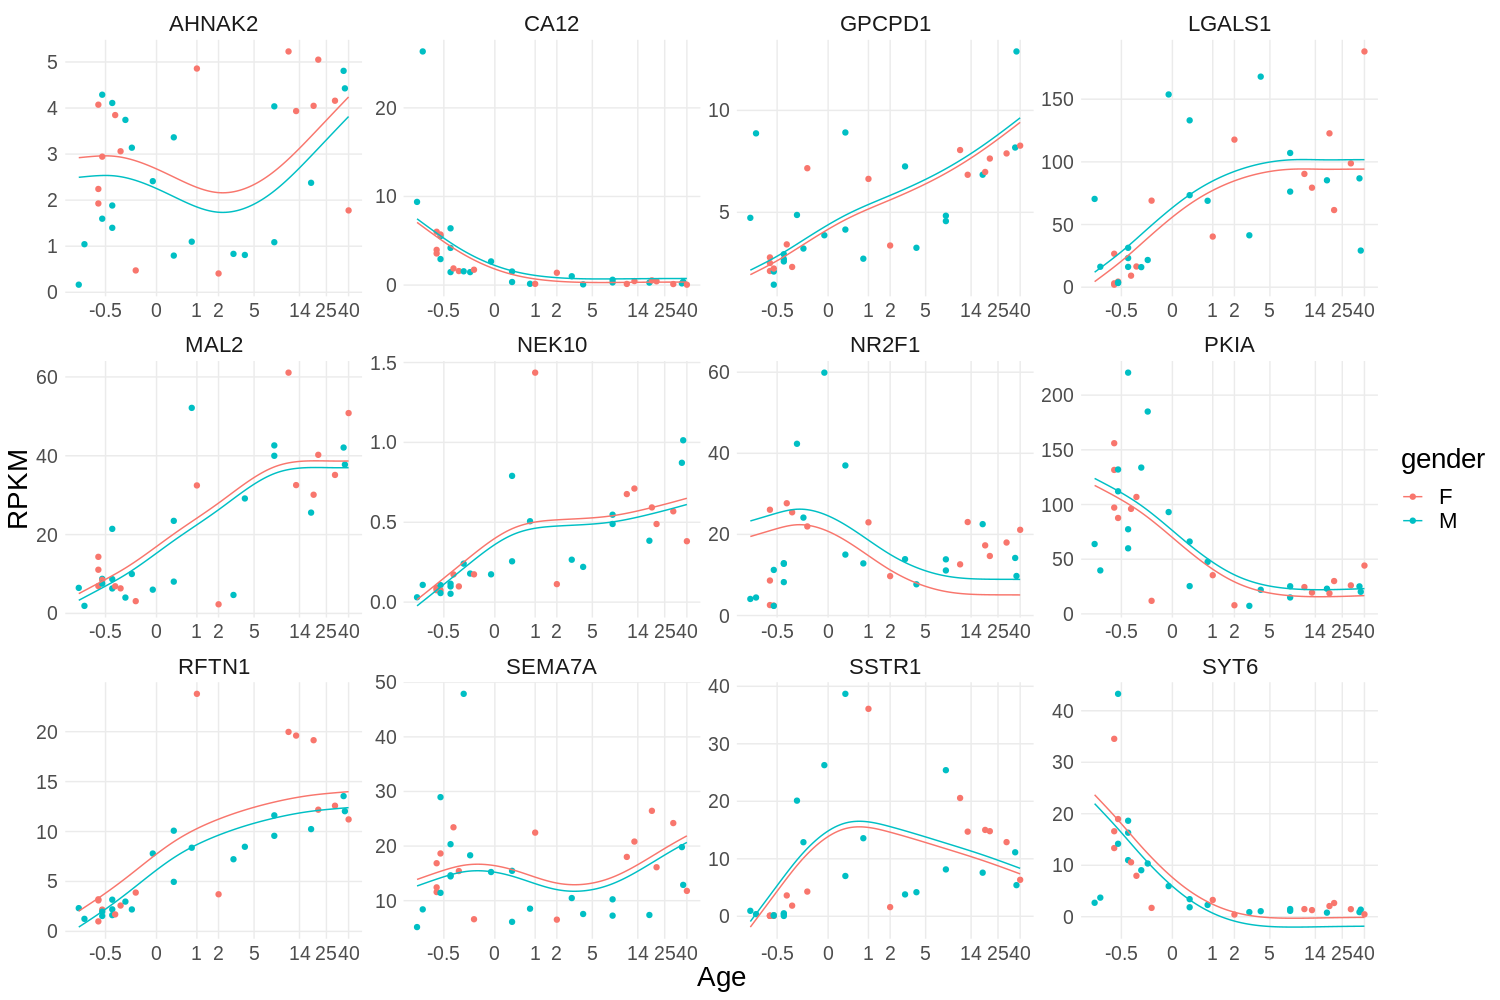

In [ ]:
%%R -i df_data -i df_preds -w 15 -h 10 -u in -r 100
ggplot(mapping=aes(x=age_log10, color=gender)) + 
facet_wrap(~gene, scales='free') +
geom_point(aes(y=true), data=df_data) + 
geom_line(aes(y=pred), data=df_preds) +
scale_x_continuous(
    breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
    labels=function(x) round((10**x - 40*7)/365,2)) +
ylab('RPKM') +
xlab('Age') +
theme_minimal() + 
theme(
    panel.grid.minor=element_blank(),
    text=element_text(size=20),
    axis.text=element_text(size=14)
)

## Fit models for all genes

In [ ]:
matched_genes = np.intersect1d(bs_clean.columns, weights.index)
models_all = fit_gam_models(bs_continuous, matched_genes)

In [ ]:
curves_all, _ = predict_gam_curves(models_all, bs_continuous, matched_genes)

In [ ]:
curves_z = (curves_all
    .loc[lambda x: np.isin(x['gene'], np.random.choice(matched_genes, 100)), :]
    .groupby(['gene', 'age_log10']).mean()
    # .assign(z = lambda x: x.groupby('gene').apply(lambda y: (y-np.mean(y))/np.std(y)))
    .assign(z = lambda x: x.groupby('gene').apply(lambda x: x/np.quantile(x, .75)))
    .reset_index()
)
curves_z

,gene,age_log10,pred,z
0,ACTN1,1.748188,2.157033,0.253580
1,ACTN1,1.772677,2.249586,0.264461
2,ACTN1,1.797166,2.342235,0.275352
3,ACTN1,1.821655,2.435365,0.286301
4,ACTN1,1.846144,2.529358,0.297351
...,...,...,...,...
9995,ZNF229,4.074647,0.851688,0.322154
9996,ZNF229,4.099136,0.842950,0.318848
9997,ZNF229,4.123625,0.834208,0.315542
9998,ZNF229,4.148114,0.825456,0.312231


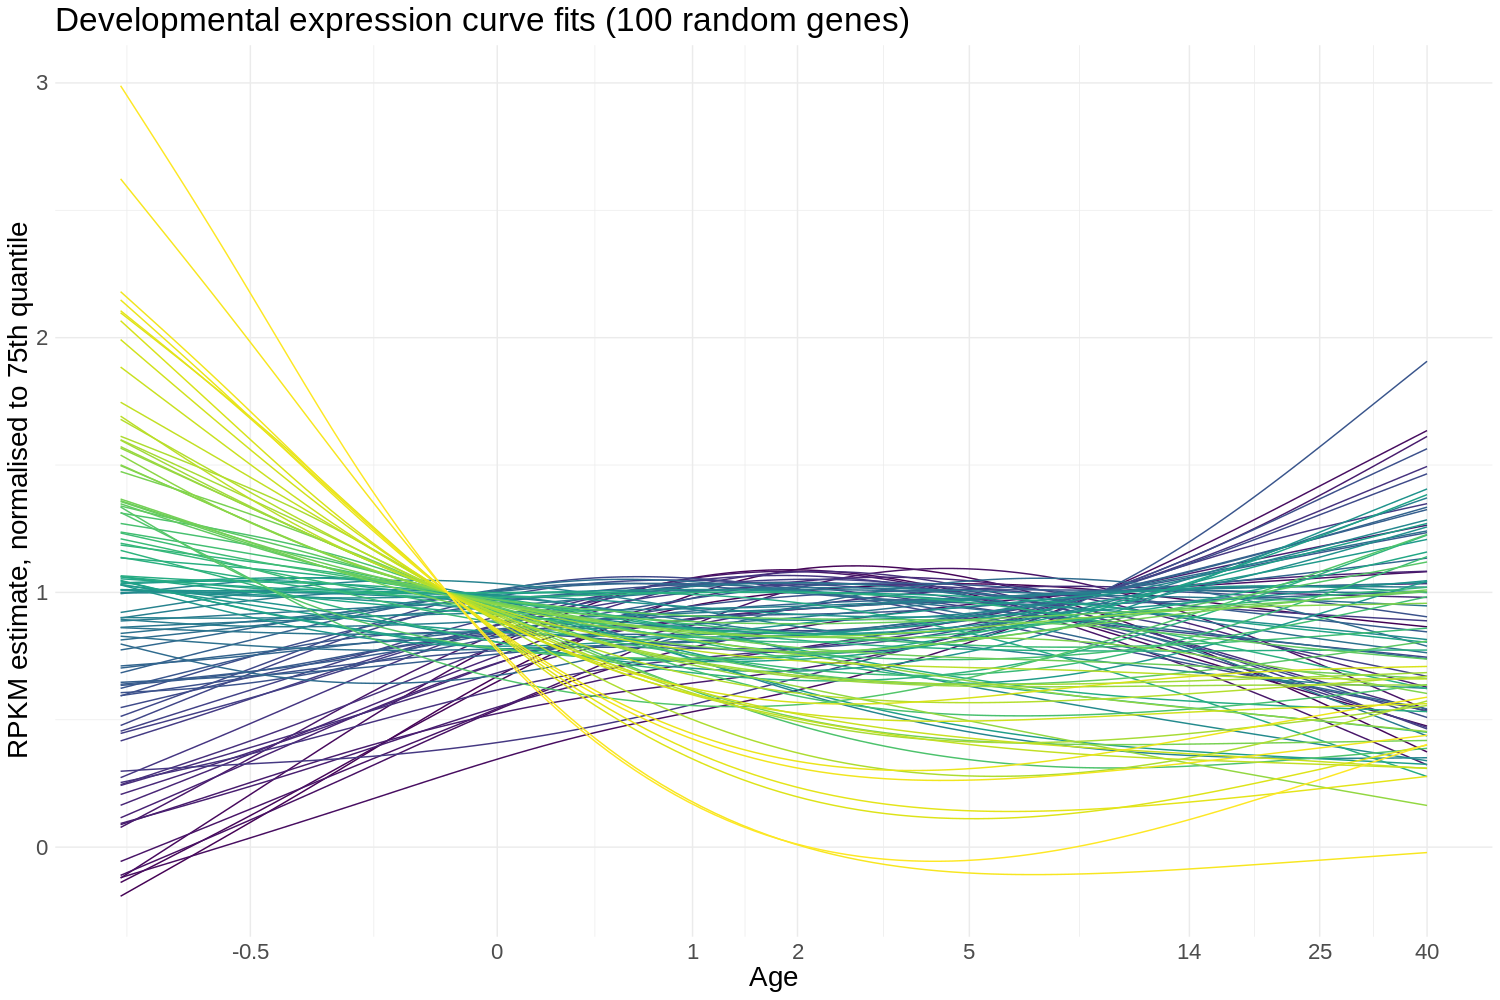

In [ ]:
%%R -i curves_z -w 15 -h 10 -u in -r 100
curves_z %>% 
arrange(age_log10) %>% 
group_by(gene) %>% 
mutate(first = first(z)) %>% 
ggplot(aes(x=age_log10, y=z)) +
geom_line(aes(color=reorder(gene, first))) +
scale_color_viridis_d() +
scale_x_continuous(
    breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
    labels=function(x) round((10**x - 40*7)/365,2)) +
ylab('RPKM estimate, normalised to 75th quantile') +
xlab('Age') +
theme_minimal() + 
theme(
    legend.position='none',
    text=element_text(size=20)
) + 
ggtitle('Developmental expression curve fits (100 random genes)')

## Peak expression for all genes

In [200]:
peaks = (curves_all
        .groupby(['gene', 'age_log10']).mean()
        .loc[lambda x: x.groupby('gene')['pred'].rank(ascending=False)==1, :]
        .reset_index()
        .rename({'age_log10':'peak_age'}, axis=1)
        .join(weights, on='gene')
)
peaks

,gene,peak_age,pred,G1,G2,G3
0,A1BG,2.874684,3.530812,-0.015451,-0.004935,0.000698
1,AAAS,1.748188,11.565152,0.011610,0.004923,0.002747
2,AAGAB,4.172603,16.277357,-0.005098,0.019884,-0.014751
3,AAK1,4.172603,11.614010,0.013312,0.001276,-0.002643
4,AARS,4.172603,101.347133,0.009905,0.014900,-0.011480
...,...,...,...,...,...,...
5991,ZSWIM7,3.364465,8.110688,-0.008451,0.015129,0.001074
5992,ZWINT,1.748188,8.393033,-0.012440,-0.008334,0.000573
5993,ZYX,2.213480,22.510712,0.017013,0.005947,-0.003734
5994,ZZEF1,1.748188,5.805342,0.013004,-0.012945,0.009700


In [216]:
%%R -i peaks -w 15 -h 10 -u in -r 100
g1 <- peaks %>% 
    ggplot(aes(x=peak_age)) + geom_density() +
    scale_x_continuous(
        breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
        labels=function(x) round((10**x - 40*7)/365,2))
g2 <- peaks %>% 
    pivot_longer(cols=G1:G3, names_to='G', values_to='G_score') %>% 
    group_by()
    ggplot(aes(x=peak_age, y=G_score)) +
    facet_grid(.~G) + 
    # geom_jitter(alpha=.5) + 
    # geom_smooth(method='lm', se=F) + 
    geom_raster(aes(fill=peak_age)) + 
    scale_fill_viridis_c() +
    scale_x_continuous(
        breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
        labels=function(x) round((10**x - 40*7)/365,2))

(g1 / g2) & 
    theme_minimal() & theme(text=element_text(size=20))

: 

: 

## DEGs